In this version, we use more epochs

In [8]:
import numpy as np
import datetime as dt
import pandas as pd
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from time_double_string import time_double,time_string
from test_correlation import lws_rbspice_loss_function_history, lws_rbspice_correlation
import copy # For early stopping best model saving
from datetime import datetime,timezone
from matplotlib import ticker, cm
import matplotlib.colors as colors
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(46)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # This is to disable GPU

np.set_printoptions(precision=4,suppress=True)
torch.set_printoptions(precision=4,sci_mode=False)
## Load geomagnetic indices from 2012-10-01 to 2018-12-31 (we need the history 
#  of geomagnetic indices to predict particle fluxes)
#  Load satellite orbit data and rbspice spinaveraged proton flux from 2013-01-01 
#  to 2018-12-31
dir0="./"
df_symh    = pd.read_csv(dir0+'lws_data/geomag_2012_2018.csv')
df_coord_a = pd.read_csv(dir0+'lws_data/coord_2013_2018_a.csv')
df_coord_b = pd.read_csv(dir0+'lws_data/coord_2013_2018_b.csv')
df_coord   = pd.concat([df_coord_a,df_coord_b],ignore_index=True)
df_flux_a  = pd.read_csv(dir0+'lws_data/rbspice_p_2013_2018_a.csv')
df_flux_b  = pd.read_csv(dir0+'lws_data/rbspice_p_2013_2018_b.csv')

# Mark data that should not be used
# Use Probe A data after 2016-11-01
# Use Probe B data before 2016-11-01
df_flux1 = df_flux_a[df_flux_a['Datetime']>"2016-11-01"]
df_flux2 = df_flux_b[df_flux_b['Datetime']<"2016-11-01"]
df_coord1 = df_coord_a[df_coord_a['Datetime']>"2016-11-01"]
df_coord2 = df_coord_b[df_coord_b['Datetime']<"2016-11-01"]
df_coord = pd.concat([df_coord2,df_coord1],ignore_index=True)
df_flux = pd.concat([df_flux2,df_flux1],ignore_index=True)
df_symh = df_symh[df_symh['Datetime']>"2013-01-01"]
df_symh.reset_index(drop=True, inplace=True)
print(df_flux.shape, df_coord.shape, df_symh.shape) # All dataframes have 631008 rows, i.e., from 2013-01-01 to 2018-12-31

# Restrict data to L>2.5, and mark data measured at L<2.5 as bad
ind_L25 = np.where(df_coord['L']<2.5)[0]
df_flux.iloc[ind_L25,1:]=np.nan

# Add a Timestamp column to df_flux, which is the number of seconds since 1970-01-01 00:
dt_obj = datetime.strptime(df_flux['Datetime'][0], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
timestamps = [int(dt_obj.timestamp()) + i*300 for i in range(len(df_flux))]
assert datetime.fromtimestamp(timestamps[-1], tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')==df_flux['Datetime'].iloc[-1], "Last timestamp does not match the last datetime in df_flux"
df_flux['Timestamp'] = timestamps

(631008, 15) (631008, 7) (631008, 15)


In [9]:
#Check Nan and Inf
datetime_arr=df_coord["Datetime"]
coord0 = df_coord.iloc[:,1:5]
symh_ae= torch.tensor(df_symh.iloc[:,[11,12,13,14]].values,dtype=torch.float32)
flux_data = torch.tensor(df_flux.iloc[:,1:].values,dtype=torch.float32)

#Coord0: Xsm,Ysm,Zsm,L, MLT，LAT
#Coord1: L, cos(theta),sin(theta),Lat; all are scaled linearly to [-1,1]
LL0 = torch.tensor(df_coord.iloc[:,4].values,dtype=torch.float32)
MLT0 = torch.tensor(df_coord.iloc[:,5].values,dtype=torch.float32)
LAT0 = torch.tensor(df_coord.iloc[:,6].values,dtype=torch.float32)
cost0=torch.cos(MLT0*np.pi/12.0)
sint0=torch.sin(MLT0*np.pi/12.0)
coord1 = torch.stack(((LL0-2.5)/(6.57-2.5)*2.0-1.0,cost0,sint0,LAT0/0.35),dim=1)#L_max = 6.57, L_min = 2.5, Lat_max = 0.35 rad

# Scale geomagnetic indices
Xlow =torch.tensor([-100.,    0.,    0.,     0.])
Xhigh=torch.tensor([  20.,  100.,  100.,  1500.]) 
for i in range(len(Xlow)):
    symh_ae[:,i] = (symh_ae[:,i] -Xlow[i])/(Xhigh[i]-Xlow[i])*2.0-1.0

symh_ae = symh_ae.to(device)
coord1 = coord1.to(device)
flux_data = flux_data.to(device)

In [10]:
# find first index that df_flux['Datetime'] > '2017-01-01 00:00:00'
ind1 = df_flux[df_flux['Datetime'] > '2017-01-01 00:00:00'].index[0]
ind2 = df_flux[df_flux['Datetime'] > '2018-01-01 00:00:00'].index[0]
episode_days = 2

episode_train,episode_valid=train_test_split(np.arange(30,ind1//288//episode_days),test_size=0.2, train_size=0.8, random_state=42) #30: remove data of first 60 days
episode_train2,episode_valid2 = train_test_split(np.arange(ind2//288//episode_days,len(df_flux)//288//episode_days), 
                                                 test_size=0.2, train_size=0.8, random_state=42)
episode_train = np.concatenate((episode_train, episode_train2 ), axis=0)
episode_valid = np.concatenate((episode_valid, episode_valid2 ), axis=0)

ind_train, ind_valid = [], []
for i in episode_train:
    ind_train.extend([j+int(i)*288*episode_days for j in range(288*episode_days)])
for i in episode_valid:
    ind_valid.extend([j+int(i)*288*episode_days for j in range(288*episode_days)])
ind_bad = torch.where(torch.isnan(flux_data).any(dim=1) | torch.isnan(coord1).any(dim=1) | torch.isnan(symh_ae).any(dim=1))[0]
bad = set(ind_bad.tolist())          # O(m), cheap membership
ind_train = [i for i in ind_train if i not in bad]   # O(n)
ind_valid = [i for i in ind_valid if i not in bad]
ind_test_full = [i for i in range(ind1, ind2)]
ind_test = [i for i in ind_test_full if i not in bad]

# one-time setup (after you build ind_*):
ind_train_t = torch.tensor(ind_train, device=device, dtype=torch.long)
ind_valid_t = torch.tensor(ind_valid, device=device, dtype=torch.long)
ind_test_t = torch.tensor(ind_test, device=device, dtype=torch.long)

print(len(ind_train), len(ind_valid), len(ind_test))

318215 80546 85723


In [ ]:
iek = 1
T_size = 12*10
batch_size = 1024
n_embd = symh_ae.shape[1]  # Number of features in the input, which is 4
block_size = T_size # Number of time steps in the input sequence
dropout = 0.2
# head_size = 2
n_head = 2 # Number of attention heads
head_size = 2
n_layer = 4 # Number of transformer blocks
n_output = 1
import torch.nn.functional as F
eval_iters =10
max_iters = 20000 # Len(ind_train) is about 320 k, max_iters * batch_size is 1,280 k
eval_interval = 100


step = 24
seq_offsets = torch.arange(-(T_size-1)*step, 1, step, device=device)  # (T_size,)


def get_batch(split):
    pool = ind_train_t if split == 'train' else ind_valid_t
    ix = torch.randint(pool.numel(), (batch_size,), device=device)     # on GPU
    base = pool[ix]                                                    # (B,)

    # 2D indices for the history window, shape (B, T_size)
    idx2d = base[:, None] + seq_offsets[None, :].to(base)

    # Gather in a single kernel each (no Python loop)
    X      = symh_ae.index_select(0, idx2d.reshape(-1)).view(batch_size, T_size, -1)
    coord  = coord1.index_select(0, base)                               # (B, 4)
    y      = flux_data.index_select(0, base)[:, iek:iek+1]              # (B, 1)

    return X, coord, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, coord, Y = get_batch(split)
            logits, loss = model(X, coord, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        tril_lowerleft = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer('tril', torch.fliplr(tril_lowerleft))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C), here C is head_size
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, 0.0) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_head*head_size, n_head*head_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, head_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head, head_size=head_size) for _ in range(n_layer)])
        # self.blocks = MultiHeadAttention(n_head, head_size)
        self.ln_f = nn.LayerNorm(n_head*head_size) # final layer norm
        # self.lm_head = nn.Linear(n_embd, 4)
        # self.lm_head1 = nn.Linear(n_head*head_size, n_head*head_size) # output layer for the attention block
        self.mlp1 = nn.Linear(n_head*head_size + 4, 15) # 4 is the number of coordinate features
        self.mlp2 = nn.Linear(15, n_output) # n_output is the
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, coord, targets=None):
        # X is (B,T,C) tensor, where B is batch size, T is sequence length, C is number of features
        # coord is (B,4) tensor, where 4 is the number of features
        # targets is (B,1) tensor, where 1 is the number of output features

        B, T, C = X.shape
        # idx and targets are both (B,T) tensor of integers
        # tok_emb = self.token_embedding_table(idx) # (B,T,C) <-- (B,T)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) <-- (T)
        x = X + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,n_head*head_size)
        x = self.ln_f(x) # (B,T,n_head*head_size)
        # x = self.lm_head1(x) # (B,T,4)

        # cancatenate the coordinate features
        coord = coord.unsqueeze(1) # (B,1,4)
        coord = coord.expand(B, T, 4) # (B,T,4)
        x = torch.cat((x, coord), dim=-1) # (B,T,n_head*head_size+4)
        x = self.mlp1(x) # (B,T,50)
        x = self.relu(x) # (B,T,50)
        # x = self.dropout(x) # (B,T,50)
        logits = self.mlp2(x) # (B,T,1)

        if targets is None:
            loss = None
        else:
            B, T, C2 = logits.shape # C2 is the number of output features
            logits = logits.view(B*T, C2)
            # expand targets from (B,1) to (B, T, 1)
            targets = targets.unsqueeze(1) # (B,1,1)
            targets = targets.expand(B, T, 1) # (B,T,1)
            targets = targets.reshape(B*T,C2)
            
            loss = F.mse_loss(logits, targets) # Mean Squared Error Loss

        return logits, loss




In [12]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
scaler = torch.amp.GradScaler()


model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# train_loss_hist = []   # store detached tensors (no sync)
# val_loss_hist = []     # store Python floats from estimate_loss()
train_loss_hist = torch.tensor([], device=device, dtype=torch.float32)  # store detached tensors (no sync)
val_loss_hist = torch.tensor([], device=device, dtype=torch.float32)    # store Python floats from estimate_loss()

for it in range(max_iters//100):
    start_time = time.time()
    loss_train_total = 0.0
    for j in range(100):
        xb, coord, yb = get_batch('train')
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            _, loss = model(xb, coord, yb)
            loss_train_total += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    
    train_loss_hist = torch.cat((train_loss_hist, torch.tensor([loss_train_total/100], device=device)), dim=0)

    losses = estimate_loss()
    val_loss_hist = torch.cat((val_loss_hist, torch.tensor([losses['val']]).to(device)), dim=0)
    # val_loss_hist.append(losses["val"])
    print(f"step {it}: train {train_loss_hist[-1]:.4f}, val {losses['val']:.4f}, time {(time.time()-start_time):.2f} s")



0.001567 M parameters
step 0: train 48.6595, val 35.9636, time 4.36 s
step 1: train 23.2503, val 9.7907, time 4.03 s
step 2: train 3.3960, val 0.5074, time 4.03 s
step 3: train 0.4412, val 0.3739, time 4.04 s
step 4: train 0.3551, val 0.3445, time 4.10 s
step 5: train 0.3305, val 0.3283, time 4.04 s
step 6: train 0.3174, val 0.3281, time 3.96 s
step 7: train 0.3096, val 0.3125, time 3.98 s
step 8: train 0.3018, val 0.3187, time 3.98 s
step 9: train 0.2970, val 0.3179, time 3.96 s
step 10: train 0.2918, val 0.3222, time 4.05 s
step 11: train 0.2901, val 0.3067, time 4.05 s
step 12: train 0.2873, val 0.2977, time 4.06 s
step 13: train 0.2758, val 0.2569, time 4.04 s
step 14: train 0.2425, val 0.2143, time 4.06 s
step 15: train 0.2264, val 0.2296, time 4.04 s
step 16: train 0.2151, val 0.2219, time 3.97 s
step 17: train 0.2083, val 0.2220, time 4.01 s
step 18: train 0.2010, val 0.2051, time 3.96 s
step 19: train 0.1937, val 0.1909, time 3.97 s
step 20: train 0.1871, val 0.1879, time 3.95 

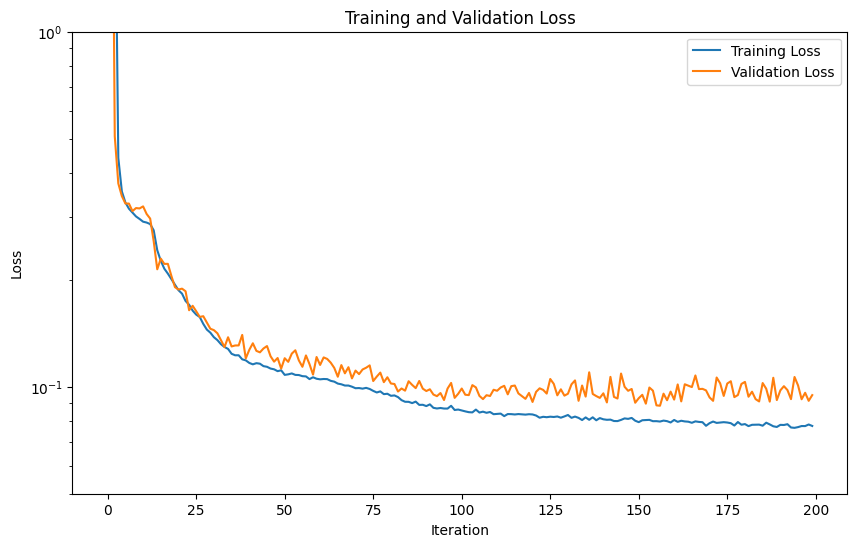

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_loss_hist.cpu(), label='Training Loss')
ax.plot(val_loss_hist.cpu(), label='Validation Loss')

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_title('Training and Validation Loss')
ax.set_ylim(0.05,1)
ax.legend()

(85723,)
0.0602002753434685


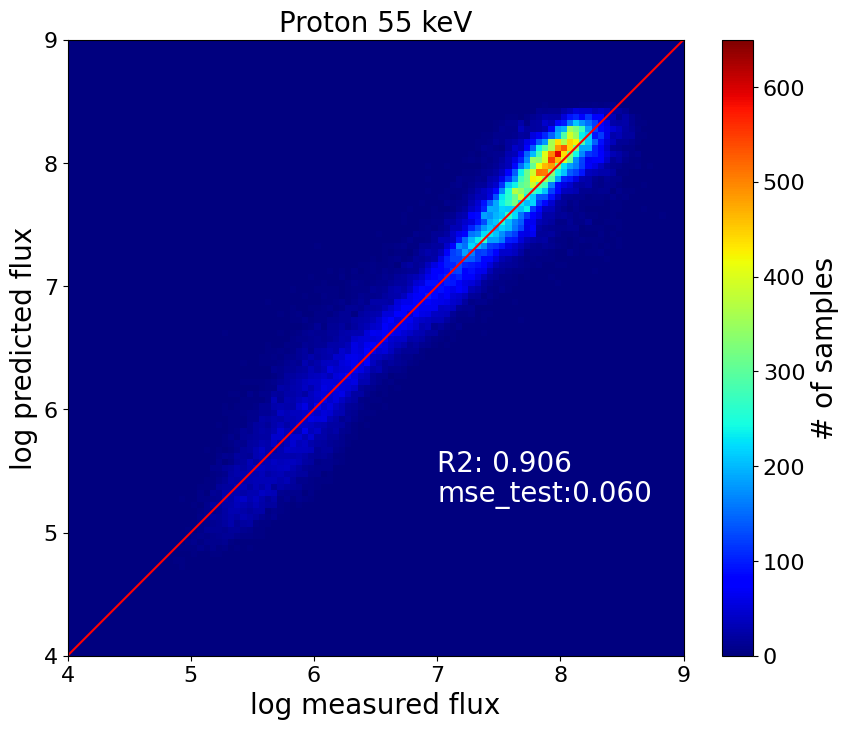

In [ ]:
y_pred = np.array([])
model.eval()  # Set the model to evaluation mode
for i in range((len(ind_test)-1)//batch_size+1):
    xb = torch.stack([symh_ae[ind_test[j]-(T_size-1)*24 : ind_test[j]+1 : 24] for j in range(i*batch_size, min(len(ind_test), (i+1)*batch_size))])
    coord = torch.stack([coord1[ind_test[j]] for j in range(i*batch_size, min(len(ind_test), (i+1)*batch_size))])
    xb = xb.to(device)
    coord = coord.to(device)
    with torch.no_grad():
        logits, _ = model(xb, coord)
    y_pred = np.concatenate((y_pred, logits[:,-1,0].cpu().numpy().flatten()), axis=0)

y_test = flux_data[ind_test, iek].detach().cpu().numpy()
from test_correlation import lws_rbspice_loss_function_history, lws_rbspice_correlation
dir_out = './results/'
fn1 = 'temp1'
lws_rbspice_correlation(y_test, y_pred, vmax=650, xrange=[4,9], figname=dir_out+'corr_'+fn1, ek=df_flux.columns[iek+1])

In [16]:
y_pred_full = np.array([])
for i in range((len(ind_test_full)-1)//batch_size+1):
    xb = torch.stack([symh_ae[ind_test_full[j]-(T_size-1)*24 : ind_test_full[j]+1 : 24] for j in range(i*batch_size, min(len(ind_test_full), (i+1)*batch_size))])
    coord = torch.stack([coord1[ind_test_full[j]] for j in range(i*batch_size, min(len(ind_test_full), (i+1)*batch_size))])
    xb = xb.to(device)
    coord = coord.to(device)
    with torch.no_grad():
        logits, _ = model(xb, coord)
    y_pred_full = np.concatenate((y_pred_full, logits[:,-1,0].cpu().numpy().flatten()), axis=0)

y_test_full = flux_data[ind_test_full, iek].detach().cpu().numpy()
print(y_pred_full.shape, y_test_full.shape)

(105120,) (105120,)


### Session 2: Compare the predicted flux and the measurements

In [22]:
## The following sections are to visulize the long-term variation of modeled proton flux
tstr_plot_begin='2017-01-01 00:00:00'
tstr_plot_end='2017-12-31 23:59:00'
class time_series():
    x = []
    y = []
    v = []
    ylabel = 'y'
    xlabel = 'x'
    linecolors = 'k'
    plot_style = 'plt'
    title= 'title'
    vrange=[]
    cmap='jet'

indt1=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1=indt1[0][0]
indt2=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2=indt2[0][-1]+1
tarr_dt=df_symh['Datetime'].astype('datetime64[ns]')[indt1:indt2].reset_index(drop=True)

t_symh = time_series()
t_symh.x = tarr_dt
t_symh.y = df_symh['SymH'][indt1:indt2].reset_index(drop=True)
t_symh.ylabel = 'SymH (nT)'

t_asyh = time_series()
t_asyh.x = tarr_dt
t_asyh.y = df_symh['AsyH'][indt1:indt2].reset_index(drop=True)
t_asyh.ylabel = 'AsyH (nT)'

t_asyd = time_series()
t_asyd.x = tarr_dt
t_asyd.y = df_symh['AsyD'][indt1:indt2].reset_index(drop=True)
t_asyd.ylabel = 'AsyD (nT)'


t_sme = time_series()
t_sme.x = tarr_dt
t_sme.y = df_symh['SME'][indt1:indt2].reset_index(drop=True)
t_sme.ylabel = 'SME (nT)'


t_sml = time_series()
t_sml.x = tarr_dt
t_sml.y = df_symh['SML'][indt1:indt2].reset_index(drop=True)
t_sml.ylabel = 'SML (nT)'


t_vx= time_series()
t_vx.x = tarr_dt
t_vx.y = df_symh['Vx'][indt1:indt2].reset_index(drop=True)
t_vx.ylabel = 'Vx km/s'

t_density = time_series()
t_density.x = tarr_dt
t_density.y = df_symh['Density'][indt1:indt2].reset_index(drop=True)
t_density.ylabel='Density'

t_pflux = time_series()
t_pflux.x = tarr_dt
t_pflux.y = df_coord['L'][indt1:indt2].reset_index(drop=True)
t_pflux.v = df_flux.iloc[:,iek+1][indt1:indt2].reset_index(drop=True)
t_pflux.ylabel = 'L'
t_pflux.plot_style = 'scatter'  # 'colorline'
t_pflux.vrange = [4, 9]

t_flux=[]
for i in range(df_flux.columns.shape[0]):
    t_flux1 = time_series()
    t_flux1.x = tarr_dt
    t_flux1.y = df_coord['L'][indt1:indt2].reset_index(drop=True)
    t_flux1.v = df_flux.iloc[:,(i+1):(i+2)][indt1:indt2].reset_index(drop=True)
    t_flux1.ylabel = 'L'
    t_flux1.plot_style = 'scatter'  # 'colorline'
    t_flux1.vrange = [4, 9]

    t_flux.append(t_flux1)
    del t_flux1

In [23]:
indt1_test=np.where((df_coord['Datetime'][ind_test_full] >= tstr_plot_begin) ) 
# probe A: ind_test < df_coord.shape[0]/2; Probe B: # probe A: ind_test >= df_coord.shape[0]/2
indt2_test=np.where((df_coord['Datetime'][ind_test_full] <= tstr_plot_end  ))
indt1_test=indt1_test[0][0]
indt2_test=indt2_test[0][-1]
ind_test_plot=ind_test_full[indt1_test:indt2_test]
tarr_test=df_coord['Datetime'].astype('datetime64[ns]')[ind_test_plot]#.reset_index(drop=True)

t_y_test = time_series()
t_y_test.x = tarr_test
t_y_test.y = df_coord['L'][ind_test_plot]
t_y_test.v = df_flux.iloc[:,iek+1][ind_test_plot]#.reset_index(drop=True)
t_y_test.ylabel = 'L'
t_y_test.plot_style = 'scatter' #'colorline'
t_y_test.vrange=[3,8]
t_y_test.title='Data'
t_y_test.cmap='jet'

t_y_pred = time_series()
t_y_pred.x = tarr_test
t_y_pred.y = df_coord['L'][ind_test_plot]
t_y_pred.v =  y_pred_full[0:len(ind_test_plot)]
t_y_pred.ylabel = 'L'
t_y_pred.plot_style = 'scatter' #'colorline'
t_y_pred.vrange=[3,8]
t_y_pred.title='Prediction'
t_y_pred.cmap='jet'

t_y_diff = time_series()
t_y_diff.x = tarr_test
t_y_diff.y = df_coord['L'][ind_test_plot]
t_y_diff.v =  y_pred_full[0:len(ind_test_plot)]-df_flux.iloc[:,iek+1][ind_test_plot].reset_index(drop=True)
t_y_diff.ylabel = 'L'
t_y_diff.plot_style = 'scatter' #'colorline'
t_y_diff.vrange=[-2,2]
t_y_diff.title='Prediction - Data'
t_y_diff.cmap='bwr'

In [24]:
t_y_test.vrange=[4,9]
t_y_pred.vrange=[4,9]

<Figure size 1800x1400 with 0 Axes>

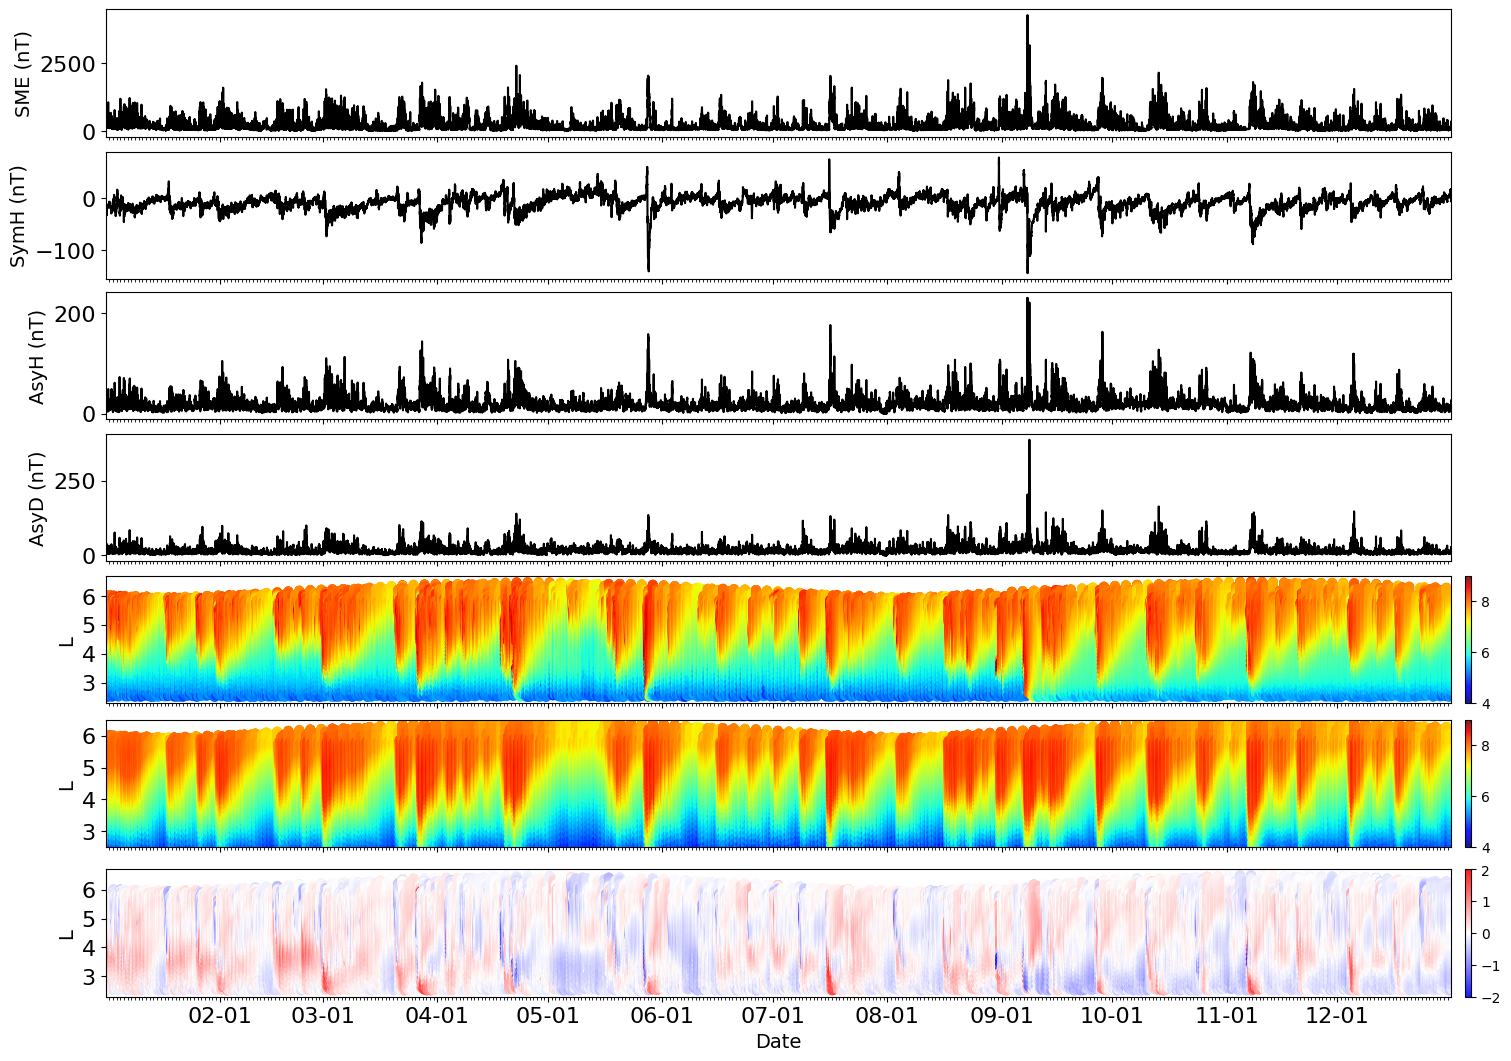

In [25]:
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
fig5=plt.figure(figsize=(18, 14),facecolor='white')   

obj_arr = [t_sme,t_symh,t_asyh,t_asyd,t_y_test,t_y_pred,t_y_diff]
n_subfig= len(obj_arr)

ax_x0=0.2
ax_y0=0.2
ax_xw=0.7
ax_yw=0.7
ax_dy_gap=0.01
ax_dy1=(ax_yw+ax_dy_gap) / n_subfig 
ax_dy0=ax_dy1-ax_dy_gap
fs_label=14

fig5, axs = plt.subplots(n_subfig,1, constrained_layout=True)
fig5.set_size_inches(15, 10.5)

for k in range(n_subfig):
    obj0=obj_arr[k]

    if obj0.plot_style == 'plt':
        s1=axs[k].plot(obj0.x,obj0.y,c=obj0.linecolors)
    elif obj0.plot_style == 'scatter':
        if not obj0.vrange:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9)
        else:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9,vmin=obj0.vrange[0],vmax=obj0.vrange[1])
        axs[k].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        fig5.colorbar(s1, ax=axs[k],fraction=0.02,pad=0.01)
        
    axs[k].set_ylabel(obj0.ylabel,fontsize=fs_label)
    
    if k !=n_subfig-1:
        axs[k].tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off
    else:
        axs[k].tick_params(axis='x',labelbottom=True) # labels along the bottom edge are on
    
    n_ts=obj0.x.shape[0]
    delta_t_days=obj0.x.reset_index(drop=True)[n_ts-1]-obj0.x.reset_index(drop=True)[0]
    if ( delta_t_days < dt.timedelta(days=30) ):
        axs[k].xaxis.set_major_locator(mdates.DayLocator())
        axs[k].xaxis.set_minor_locator(mdates.HourLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    else:
        axs[k].xaxis.set_major_locator(mdates.MonthLocator())
        axs[k].xaxis.set_minor_locator(mdates.DayLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axs[k].tick_params(axis='both', which='major', labelsize=16)
    axs[k].tick_params(axis='both', which='minor', labelsize=12)
    axs[k].set_xlim(obj0.x.iloc[0],obj0.x.iloc[-1])
axs[5].set_ylim(2.5,6.5)
axs[k].set_xlabel('Date',fontsize=fs_label)
figname=dir_out+'long_term_'+fn1
#fig5.savefig(figname+"_6.pdf",format='pdf')
fig5.savefig(figname+"_6.png", format="png", dpi=300)

plt.show()

### Use the RCPANN model to produce global distribution of proton fluxes
This session shows how to use the RCPANN model to produce a global distribution of spin-averaged proton flux at a specific energy, which is stored in "y_pred_matrix". The data y_pred_matrix is the equatorial proton flux in the Xrange of [-6.5, 6.5] and Yrange of [-6.5, 6.5], but only those in the in the radial distance range [2.5, 6.5] are trustful. 

In [ ]:
# Definitions for Global distribution
xrange=[-6.5,6.5]
yrange=xrange
delta = 0.1
NX=int((xrange[1]-xrange[0])/delta)
NY=int((yrange[1]-yrange[0])/delta)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
XX, YY = np.meshgrid(x, y)


XX_flat=XX.flatten()
YY_flat=YY.flatten()
RR_flat=np.sqrt(XX_flat**2+YY_flat**2)
sint_flat = -YY_flat/RR_flat #Since we defined sint = sin(MLT/12*!pi)
cost_flat = -XX_flat/RR_flat
LAT_flat = XX_flat*0.0
#zero_glb=XX_flat*0.0
LL_flat=(RR_flat-2.5)/(6.57-2.5)*2.0-1.0 # scale from [2.5,6.57] to [0,1]

coord_glb=np.concatenate((LL_flat.reshape([-1,1]),cost_flat.reshape([-1,1]),sint_flat.reshape([-1,1]),LAT_flat.reshape([-1,1])), axis=1)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
X, Y = np.meshgrid(x, y)
vmax=9.0
vmin=5.0
norm = mpl.cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = mpl.cm.jet

In [ ]:
# Compare the period 2015-03-15/12 to 2015-03-20/00
tstr1='2017-03-01 00:02:00'
tstr2='2017-03-04 23:57:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr1)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] >= tstr2)
indt2_symh=indt2_symh[0][0]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)


indt1_coord=np.where(df_coord['Datetime'] >= tstr1)
indt1_coord=indt1_coord[0][0]
indt2_coord=np.where(df_coord['Datetime'] >= tstr2)
indt2_coord=indt2_coord[0][0]+1



In [ ]:
tarr_dt[200]

In [ ]:

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

ax_x0=0.2
ax_dx=0.7
ax_dy=0.10
ax_dy_1=0.097
ax_y0=0.55

for k in [200]: #(0,tarr_dt.size,4): [32,200,272]
    tbar=tarr_dt[k]
    indt_glb_1=k+indt1_coord
    fig4=plt.figure(figsize=(8,8),facecolor='white')   
    
    n_fig=4
    #fig = plt.figure(figsize=(18, 14),facecolor='white')   
    fs_label=12
    fs_major=12
    fs_minor=9

    ax1=fig4.add_subplot(n_fig,1,1)
    ax1.set_position([ax_x0,ax_y0+3*ax_dy,ax_dx,ax_dy_1])
    ax1.plot(tarr_dt,df_symh['SymH'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax1. get_ylim()
    ax1.plot([tbar,tbar],[y_min,y_max],':g')
    ax1.set_ylabel("Sym-H (nT)",fontsize=fs_label)
    ax1.tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off

    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.tick_params(axis='both', which='major', labelsize=fs_major)
    ax1.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax2=fig4.add_subplot(n_fig,1,2)
    ax2.set_position([ax_x0,ax_y0+2*ax_dy,ax_dx,ax_dy_1])
    ax2.plot(tarr_dt,df_symh['AsyH'][indt1_symh:indt2_symh],'k')
    ax2.plot(tarr_dt,df_symh['AsyD'][indt1_symh:indt2_symh],'r')
    y_min, y_max = ax2. get_ylim()
    ax2.plot([tbar,tbar],[y_min,y_max],':g')
    ax2.set_ylabel("Asym (nT)",fontsize=fs_label)
    ax2.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_minor_locator(mdates.HourLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.tick_params(axis='both', which='major', labelsize=fs_major)
    ax2.tick_params(axis='both', which='minor', labelsize=fs_minor)
    ax2.legend(('AsyH', 'AsyD'), loc='upper right',fontsize=fs_label)


    ax3=fig4.add_subplot(n_fig,1,3)
    ax3.set_position([ax_x0,ax_y0+1*ax_dy,ax_dx,ax_dy_1])
    ax3.plot(tarr_dt,df_symh['SME'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax3. get_ylim()
    ax3.plot([tbar,tbar],[y_min,y_max],':g')
    ax3.set_ylabel("SME (nT)",fontsize=fs_label)
    ax3.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)



    #Subfigure 4
    X_1=X_y_all[indt_glb_1,0:N_ftr].copy()
    X_1_mat=np.matmul(np.ones([NX*NY,1]),X_1.reshape([1,len(X_1)]))
    X_glb=np.concatenate((X_1_mat,coord_glb),axis=1)
    y_glb_pred=model.predict(X_glb)
    y_pred_matrix=y_glb_pred[:,0].reshape([NX,NY])

    ax0=fig4.add_subplot(5,1,5)
    ax0.set_position([0.25,0.08,0.5,0.5])
    im = ax0.contourf(X, Y, y_pred_matrix,  256,cmap=mpl.cm.jet,vmax=vmax,vmin=vmin)

    #Set L>6.5 and L<2 blank
    theta2=np.arange(0,2.01*np.pi,0.02)
    r2=np.arange(6.5,9.5,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im3=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    r2=np.arange(0.0,2.0,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im4=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)


    #Add Earth
    theta=np.arange(0,2.01*np.pi,0.1)
    ax0.plot(np.cos(theta),np.sin(theta),'k')
    r=np.arange(0,1.1,0.1)
    theta1=np.arange(0.5*np.pi,1.5*np.pi,0.02)
    R,THETA=np.meshgrid(r,theta1)
    X1=R*np.cos(THETA)
    Y1=R*np.sin(THETA)
    im2=ax0.contourf(X1,Y1,X1*0+0.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    #Add 0, 6, 12, 18 sectors and L=4,6
    ax0.plot([-6,6],[0,0],':k',linewidth=1)
    ax0.plot([0,0],[-6,6],':k',linewidth=1)
    ax0.plot(6*np.cos(theta),6*np.sin(theta),':k')
    ax0.plot(4*np.cos(theta),4*np.sin(theta),':k')

    #ax0.set_title('Proton 7.1 keV',fontsize=20)
    ax0.set_xlabel("X_sm",fontsize=fs_label)
    ax0.set_ylabel("Y_sm",fontsize=fs_label)
    ax0.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.tick_params(axis='both', which='major', labelsize=fs_label)
    ax0.tick_params(axis='both', which='minor', labelsize=fs_label)
    plt.axis('equal')
    ax0.set_xlim([-6.5,6.5])
    ax0.set_ylim(-6.5,6.5)
    ax0.invert_xaxis()
    ax0.invert_yaxis()

    # Add colorbar
    cax = plt.axes([0.8, 0.08, 0.01, 0.5])
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0,cax=cax)
    cbar.ax.tick_params(labelsize=fs_label)
    cbar.set_label('log proton flux '+str(df_flux.columns[iek+1])+' keV', fontsize=fs_label)
    ax0.set_title(tbar.strftime("%Y-%m-%d %H:%M"),fontsize=fs_label)
    dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/global8/'
    os.makedirs(dir_out, exist_ok = True) 
    plt.savefig(dir_out+"proton_'+str(df_flux.columns[iek+1])+'_kev_global"+str(k)+".png", format="png", dpi=300)
    #plt.savefig(dir_out+"proton_55_kev_global"+str(k)+".pdf",format='pdf')
    #plt.show()
